This notebook shows some of the visulisation utility of Lyft l5 toolkit.

The core packages for visualisation are:

* 1.rasterization
* 2.visualization

Along with the information regarding Maps that Lyft uses for Motion planning


In [ ]:
!pip install --upgrade pip
!pip install pymap3d==2.1.0
!pip install -U l5kit


Rasterisation is the task of taking an image described in a vector graphics format and converting it into a raster image.

* BoxRasterizer: this object renders agents (e.g. vehicles or pedestrians) as oriented 2D boxes
* SatelliteRasterizer: this object renders an oriented crop from a satellite map

# These HD maps need to represent the world at an unprecedented centimeter resolution, which is one to two orders of magnitude greater than the roughly meter level resolution that web map services offer today.

# HD MAP Principles:
1.**Mapping as pre-computation** :  Perception and localization of static objects in the world such as roads, intersections, street signs, etc. can be solved offline and in a highly accurate manner .This are some of the things that could be precomputed before the AV starts driving.

2.**Mapping to improve safety**: Level 5 HD maps are designed not only to contain speed limit information for each lane segment, but also speed profiles derived from actual human drivers on the Lyft network that meet our high bar for safety.

3.**Map as a unique sensor**: Viewing the map as yet another sensor allows us to design efficient map access patterns and integrate map data more naturally into the autonomy stack (e.g. sensor-fusion components).

4.**Map as global shared state:** The map then becomes a shared data structure that lives both in the cloud and also docked in each of the AVs. AVs use the map to both read and write to this social memory.


# # Layering In HD Maps:


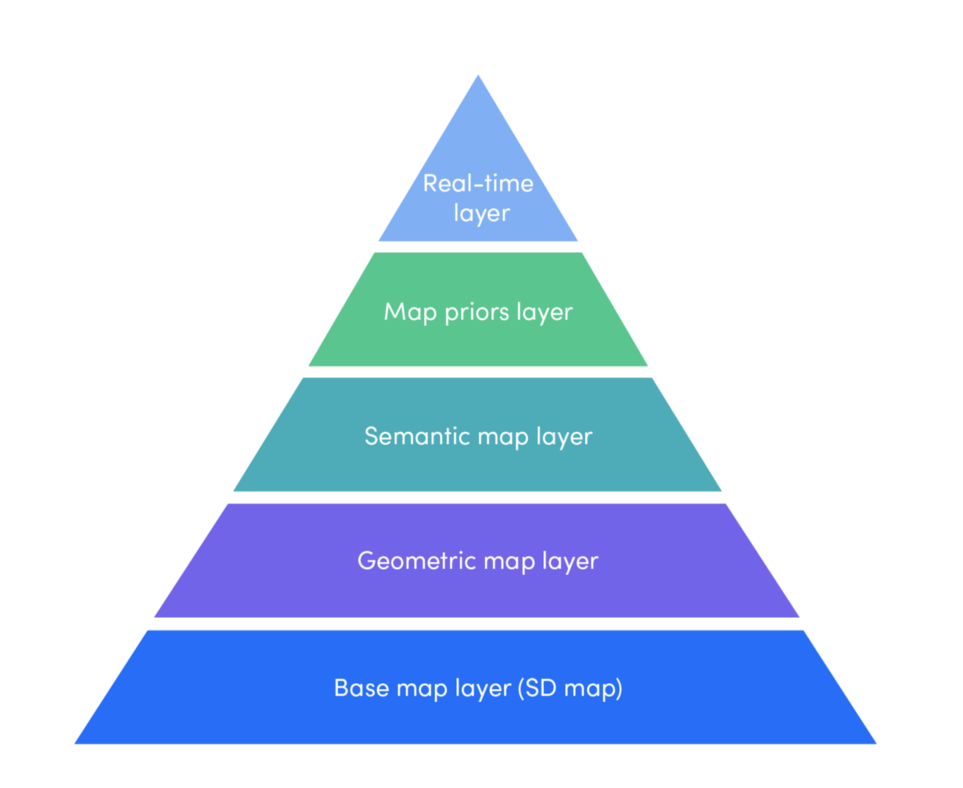

# Four noteworthy HD layers are: 
1. The geometric map : The geometric map layer contains 3D information of the world. This information is organized in very high detail to support precise calculations. The ground map is key for aligning the subsequent layers of the map, such as the semantic map.

2. The semantic map : Semantic objects include various traffic 2D and 3D objects such as lane boundaries, intersections, crosswalks, parking spots, stop signs, traffic lights, etc. that are used for driving safely. These objects contain rich metadata associated with them such as speed limits and turn restrictions for lanes. 

3. Map priors :The map priors layer contains derived information about dynamic elements and also human driving behavior. Information here can pertain to both semantic and geometric parts of the map

4. Real-time knowledge:The real-time layer is the top most layer in the map and is designed to be read/write capable. This is the only layer in the map designed to be updated while the map is in use by the AV serving a ride

Source  : https://medium.com/lyftlevel5/https-medium-com-lyftlevel5-rethinking-maps-for-self-driving-a147c24758d6




In [ ]:
import l5kit, os
import matplotlib.pyplot as plt
import numpy as np
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable
from matplotlib import animation, rc
from IPython.display import HTML


# Setup Environment Variable and Configs:

In this yaml file we have the necessary configs
1. Model Params
2. Input Image Raster Params
3. The DataLoader params


In [ ]:
os.environ["L5KIT_DATA_FOLDER"] = "../input/lyft-motion-prediction-autonomous-vehicles"
cfg = load_config_data("../input/lyft-config-files/visualisation_config.yaml")

# DATA LOADING :

LocalDataManager object resolves**** relative paths from the config using the L5KIT_DATA_FOLDER env variable we have just set.

In [ ]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

# The Exploration of individual Images would help us to gain more insights into the data
1. Trajectory Of AV
2. Satellite View
3. Semantic Veiw



In [ ]:
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

plt.imshow(im[::-1])
plt.show()

This shows the way to visualize a sample from our dataset

We use Rasterizer to get an rgb format and then plot .

The target positions can be changed with the pixel co-ordinates necssary for knowing the ground truth.


In [ ]:
cfg["raster_params"]["map_type"] = "py_semantic"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

plt.imshow(im[::-1])
plt.show()

The green blob represents the AV's motion, and we would require to predict the movement of the AV in these traffic conditions as a sample.

In [ ]:
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

plt.imshow(im[::-1])
plt.show()

# Satellite View
This is the Satellite View of the Scene .  Where the Pink Trajectory seems to be the line of motion ie the expected trajectory of the AV

In [ ]:
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
scene_idx = 2
indexes = dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
    clear_output(wait=True)
    display(PIL.Image.fromarray(im[::-1]))

Analysis:
The Green Blob is our Autonomous vechicle
I think that the Blue Blobs are the Path to be taken by our vehicle . As we are able to generate the path for our movement this will help to tackle obstacle in a better way

# Semantic View
THis is the Semantic view of the scene

In [ ]:
import numpy as np
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_semantic"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
scene_idx = 2
indexes = dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
    clear_output(wait=True)
    display(PIL.Image.fromarray(im[::-1]))

Analysis:
Intersection of 4 road would be seen . 
The yellow Lines are the various Lanes possible .
Maybe the red Path indicates the various Trajectories possible for our AV to take.


# Entire Motion 
Entire Motion of the Av wrt other vehicles and its trajectory planning would be seen from this.

In [ ]:
from IPython.display import display, clear_output
from IPython.display import HTML

import PIL
import matplotlib.pyplot as plt
from matplotlib import animation, rc
def animate_solution(images):

    def animate(i):
        im.set_data(images[i])
 
    fig, ax = plt.subplots()
    im = ax.imshow(images[0])
    
    return animation.FuncAnimation(fig, animate, frames=len(images), interval=60)
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
scene_idx = 34
indexes = dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
    clear_output(wait=True)
    images.append(PIL.Image.fromarray(im[::-1]))
anim = animate_solution(images)
HTML(anim.to_jshtml())

Analysis:
This Shows the real time ( actual path planning done by Autonomous vehicle ) . With Blue being the possible Paths to take.

Additional Sources and Info :
https://medium.com/lyftlevel5/continued-momentum-through-simulation-8b9a8df79f3b

https://github.com/lyft/l5kit/

https://medium.com/lyftlevel5/lyfts-approach-to-autonomous-vehicle-safety-fc771ed25786

https://github.com/lyft/l5kit/tree/master/examples/visualisation

https://arxiv.org/pdf/1912.11676.pdf

Thankyou For reading !!